#**Potential Talents**

In [ ]:
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random

import nltk
from nltk import word_tokenize, ngrams
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from scipy.spatial.distance import cosine


!pip install --upgrade gensim
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [2]:
# Now, we can read the .csv file from desktop
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

In [3]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


####**Data Wrangling**

In [4]:
# Drop fit column and explore duplicate rows
df.drop('fit', axis = 1, inplace = True)             
df_dup = df.drop(['id'], axis = 1)                    
print("Number of duplicate entries:", df_dup.duplicated().sum()) 

Number of duplicate entries: 51


In [5]:
# See duplicate entries
df[df_dup.duplicated(keep=False)] 

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+
...,...,...,...,...
60,61,HR Senior Specialist,San Francisco Bay Area,500+
61,62,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+
62,63,Student at Chapman University,"Lake Forest, California",2
63,64,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+


In [6]:
# Drop duplicate rows and rebuild dataframe
df_dup = df_dup.drop_duplicates()                                    
df = pd.concat([df['id'], df_dup], axis = 1).dropna(axis = 0)   
print("Shape of non-duplicated dataframe:", df.shape) 

Shape of non-duplicated dataframe: (53, 4)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53 non-null     int64 
 1   job_title   53 non-null     object
 2   location    53 non-null     object
 3   connection  53 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [8]:
df['location'] = df['location'].replace(to_replace = ['Kanada', 'Türkiye', 'Amerika Birleşik Devletleri'], 
                                            value = ['Canada', 'Turkey', 'USA'], 
                                            regex = True)

# Replace 'HR' by 'Human Resources'
df['cleaned_job_title'] = df['job_title'].str.replace("HR", " Human Resources ") 

# Removing unnecssary characters like  commas, periods etc. 
df['cleaned_job_title'] = df['cleaned_job_title'].str.replace(r"[^a-zA-Z0-9\' ']", "")
df['cleaned_job_title'] = df['cleaned_job_title'].str.replace(r"\'s", " ")
df['cleaned_job_title'] = df['cleaned_job_title'].str.lower()
df = df.reset_index(drop = True)
df.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer college of business graduate mag...
1,2,Native English Teacher at EPIK (English Progra...,Canada,500+,native english teacher at epik english program...
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator at ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Turkey",500+,advisory board member at celal bayar university


In [9]:
# Remove stop words and lemmatize words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range (0, len(df)):
    word_tokens = word_tokenize(df['cleaned_job_title'][i])
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    lemmatized_sentence = []
    for word in filtered_sentence:
        lemmatized_sentence.append(lemmatizer.lemmatize(word))
    df['cleaned_job_title'][i] = TreebankWordDetokenizer().detokenize(lemmatized_sentence)

df.head()

,id,job_title,location,connection,cleaned_job_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer college business graduate magna ...
1,2,Native English Teacher at EPIK (English Progra...,Canada,500+,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Turkey",500+,advisory board member celal bayar university


####**Exploratory Data Analysis**

In [10]:
X_job = df['cleaned_job_title'].values

In [11]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [12]:
def plot_scatter(df, keyword, title):
    # This will group based on the different labels
    sns.scatterplot(x = 'x', y = 'y', hue = 'results', data = df, palette = sns.color_palette("tab10", 
                                                            len(df['results'].unique())))
    # The keywords will be plotted in the space 
    plt.scatter(keyword[0][0], keyword[0][1], s = 70, marker = 'X', color = 'black')
    plt.legend(loc = (1.05, 0.5))
    plt.title(title)
    return plt.show()

def get_unigram(question):
    doc = nlp(question)
    word_list =  [word.lemma_ for word in doc]
    return  [word for word in word_list if word not in stop_words]

def create_results_df(X, preprocessing, predictions):
    # Save the points with the predictions
    df = pd.DataFrame(preprocessing, columns = ['x', 'y'])
    df['results'] = predictions
    df['cleaned_job_title'] = X
    
    return df 


def euclidean_distance(df, keyword):
    #Euclidean distance use the pythagoras theorem to calculate the distance between two coordenates
    distance = [np.sqrt(((
                    df.iloc[i][0] - keyword[0][0]) ** 2) 
                        + ((df.iloc[i][1] - keyword[0][1]) ** 2)) for i in range(0, len(df))]
    df['euclidean_distance'] = distance
    df = df.reset_index(drop = True)
    return df


def create_pipeline(preprocessor,  model):
    preprocessing_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('pca', TruncatedSVD(n_components = 2))
                                  ])
    
    model_pipeline = Pipeline([('preprocessor', preprocessing_pipeline),
                       ('clustering', model)                           
                       ])
    
    return model_pipeline

def model_fit(pipeline, X, string):
    pipeline.fit(X)
    preprocessed_data = pipeline['preprocessor'].transform(X)
    predicted_labels = pipeline['clustering'].labels_
    clusters = pipeline['clustering'].cluster_centers_
    keywords_transformed = pipeline['preprocessor'].transform([string])
    
    return preprocessed_data, predicted_labels, keywords_transformed


def create_nlp_model(X, string, preprocessor, model):
    pipe = create_pipeline(preprocessor,  model)
    preprocessed_data, predicted_labels, keywords_transformed = model_fit(pipe, X, string)
    result_df = create_results_df(X, preprocessed_data, predicted_labels)
    plot_scatter(df = result_df, keyword = keywords_transformed, title = 'KMeans Clusters for job keywords')
    plt.show()
    result_df = euclidean_distance(result_df, keywords_transformed)
    return result_df


    
       

In [13]:
clusters = np.arange(2,10,1)

preprocessed_data = TfidfVectorizer().fit_transform(X_job)

preprocessed_data = preprocessed_data.todense()

for n_clusters in clusters:

    predictor = KMeans(n_clusters)
    cluster_labels = predictor.fit_predict(preprocessed_data)

    # The silhouette_score gives the average value for all samples.
    # This gives a perspective into the density and separation of clusters

    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.0548392844384963
For n_clusters = 3 The average silhouette_score is : 0.02911584438381297
For n_clusters = 4 The average silhouette_score is : 0.03526625111485045
For n_clusters = 5 The average silhouette_score is : 0.034626932874078725
For n_clusters = 6 The average silhouette_score is : 0.044188687583684376
For n_clusters = 7 The average silhouette_score is : 0.05402150388574905
For n_clusters = 8 The average silhouette_score is : 0.059622713132949
For n_clusters = 9 The average silhouette_score is : 0.05042589873436238


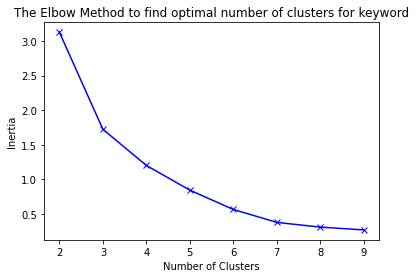

In [14]:
distortions = []

for c in clusters:
    Kmeans_pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                                ('pca', TruncatedSVD(n_components = 2)),
                           ('clustering', KMeans(c))                           
                           ])
    Kmeans_pipeline.fit(X_job)
    distortions.append(Kmeans_pipeline['clustering'].inertia_)
    
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method to find optimal number of clusters for keyword')
plt.xticks(clusters)
plt.show()   

The "elbow" is visible at 3 signifying that 3 clusters would be ideal but we will use 4 clusters for visual appeal.  Below, we will define our keywords for which we will compare all other job titles initially with cluster analysis and later with vector similarity.

In [15]:
keywords = 'seeking aspiring human resources'
keywords_processed = ' '.join(get_unigram(keywords))

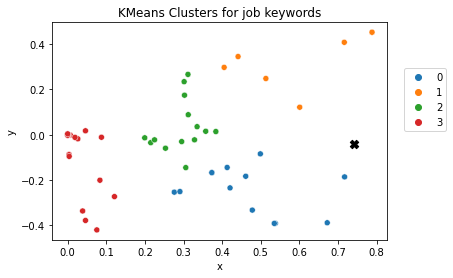

In [16]:
cv_df_job = create_nlp_model(X_job, keywords_processed, TfidfVectorizer(), KMeans(4))

It appears as if two clusters have job titles that are close to the keywords.  It could be that some job titles may have either "seeking" or "aspiring" in the job title.  

In [17]:
text = " ".join(word for word in df.cleaned_job_title)
print ("There are {} words in the combination of all job titles.".format(len(text)))

There are 2822 words in the combination of all job titles.


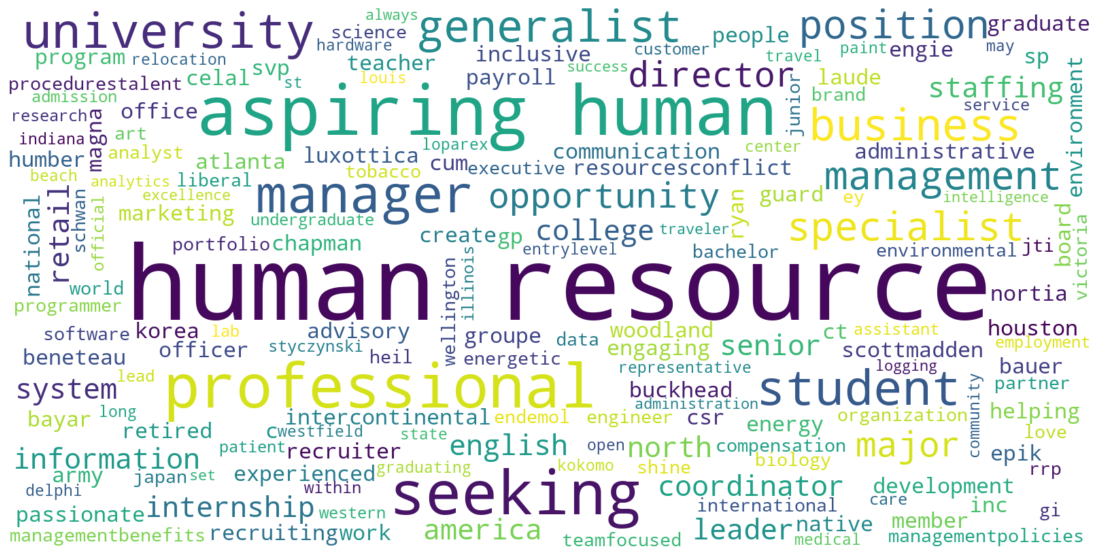

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=1600, height=800).generate(text)

# Display the generated image the matplotlib way:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

No surprise that human, resource, aspiring, seeking and professional are most relevant.  There are a large number of listings for management and students indicating that there is a broad range of experience levels in the job listings. Wordclouds help with generalizing over a broad range of text and also is useful in sentiment analysis.  For some reason, human is listed twice?  

####**Vectorize**

In [18]:
# Convert job titles column to list
job_title_list = list(df['cleaned_job_title'])                    

# Vectorize job_title_list
vectorizer = TfidfVectorizer()                                 
vectorizer.fit(job_title_list)                    
X = vectorizer.transform(job_title_list)    

In [19]:
# Get feature count in all of the job titles
feature_names = vectorizer.get_feature_names()                  
print("Number of unique features: ", len(feature_names))   

Number of unique features:  177


In [20]:
# Convert job titles into arrays
tfidf_vector = X.toarray()                                  
print("Shape of Tfidf vector: ", tfidf_vector.shape)

Shape of Tfidf vector:  (53, 177)


####**Cosine Similarity**

In [21]:
def cosine_similarity(vector_1, vector_2):
    cos_sim = 1 - cosine(vector_1, vector_2)        
    return cos_sim

In [22]:
lemmatized_phrase = []
tokenized_phrase = word_tokenize(keywords.lower())
for word in tokenized_phrase:
    lemmatized_phrase.append(lemmatizer.lemmatize(word))
lemmatized_phrase = TreebankWordDetokenizer().detokenize(lemmatized_phrase)

# Convert search phrase into a vector
X1 = vectorizer.transform([lemmatized_phrase])                    
X1_vector = X1.toarray()
print("Search phrase vector shape:", X1_vector.shape)

Search phrase vector shape: (1, 177)


In [23]:
tfidf_list = []
for x in range (0, len(df)):
    tfidf_list.append(cosine_similarity(tfidf_vector[x], X1_vector))

df['tfidf_score'] = tfidf_list
df.sort_values(by ='tfidf_score', ascending = False).head(10)

,id,job_title,location,connection,cleaned_job_title,tfidf_score
21,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspiring human resource manager seeking intern...,0.698165
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839
12,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,aspiring human resource management student see...,0.558855
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179
48,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,aspiring human resource manager graduating may...,0.399144
20,72,Business Management Major and Aspiring Human R...,"Monroe, Louisiana Area",5,business management major aspiring human resou...,0.326453


Our TF-IDF similarity scores are not great scores.  This does not necessarily mean that it is good or bad but we may need a more sophisticated algorithm for prediction as the first listing is for a manager internship which may not be exactly what the HR team is looking for but it does contain both "aspiring" and "seeking" in the job title.  

####**Word Embedding - changing words into vectors**

**GloVE**

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [24]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving glove.6B.300d.txt to glove.6B.300d.txt


In [25]:
%%time
# Create temp file and save converted embedding to it
target_file = get_tmpfile('word2vec.6B.300d.txt')
glove2word2vec('glove.6B.300d.txt', target_file) 
 
# Load converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary
glove_model.save_word2vec_format('word2vec.6B.300d.bin.gz', binary=True)

CPU times: user 3min 45s, sys: 10.8 s, total: 3min 56s
Wall time: 3min 39s


Below is the token_vectors function which will be used for all models to return vectors of words needed to find the cosine similarity or similarity scores for the model used.

In [26]:
def token_vectors(sentence, model, sentence_vector_list, vector_dimensions):
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
    
    for j in range(0, len(word_tokens)):
        if word_tokens[j] in filtered_words:
            token_vector = model[word_tokens[j]]
        else:
            token_vector = np.zeros(vector_dimensions)
        sentence_vector_list.append(token_vector)
    
    return sentence_vector_list

In [27]:
glove_vectors = []
for i in range(0, len(df)):
    glove_sentence_vector = []
    token_vectors(df['cleaned_job_title'][i], glove_model, glove_sentence_vector, 300)
    glove_vectors.append(glove_sentence_vector)

In [28]:
glove_search_phrase_vector = []
token_vectors(lemmatized_phrase, glove_model, glove_search_phrase_vector, 300)

[array([-1.6596e-01, -4.1787e-01, -8.7294e-02,  1.4863e-01,  1.1291e-01,
        -3.5616e-01,  4.6915e-01, -8.2795e-02,  4.7348e-01, -1.2572e+00,
         2.5673e-01, -3.4095e-02,  7.5899e-02,  1.5982e-01, -4.1140e-01,
        -1.6535e-01, -3.5117e-01,  4.5734e-01, -2.5565e-01, -2.8134e-01,
        -1.7524e-03, -7.5747e-03,  2.7877e-01, -1.1567e-01, -5.4568e-01,
        -3.8182e-01,  1.0837e-01,  7.2153e-02,  3.8625e-02,  2.5528e-01,
        -6.1201e-01, -1.8030e-01,  1.2600e-01, -3.4010e-01, -8.5556e-01,
        -2.9387e-01,  9.7063e-03, -3.2650e-01,  4.9453e-02, -2.3463e-01,
        -1.8007e-01,  3.1352e-01, -3.4694e-02,  4.2066e-02,  1.1291e-01,
        -1.9306e-01, -6.4301e-02, -2.0602e-01, -9.2576e-04, -3.6607e-01,
         2.9894e-01, -3.3745e-01,  3.9893e-01, -1.0808e-01,  4.9517e-01,
         1.7519e-01, -8.6770e-02,  4.7674e-01,  8.9017e-02, -2.8983e-01,
        -3.2157e-01, -7.6752e-02,  2.0005e-01, -1.1845e-01,  4.6096e-02,
        -1.5749e-01, -3.2510e-01, -1.8036e-01,  1.5

Below, we need to find the averages of the words in the sentence to represent one unique vector and compare that vector to the keywords vector with the cosine similarity function to contrive a similarity score and rank by that score, which in this case is derived from the GloVe model.

In [29]:
glove_similarity = []
for i in range(0, len(df)):
    sim_score = cosine_similarity(np.mean(glove_vectors[i], axis = 0), np.mean(glove_search_phrase_vector, axis = 0))
    glove_similarity.append(sim_score)

# Add GloVe similarity score to df
df['GloVe_score'] = glove_similarity
df.sort_values(by ='GloVe_score', ascending = False).head(20)


,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score
21,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspiring human resource manager seeking intern...,0.698165,0.922625
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731
12,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,aspiring human resource management student see...,0.558855,0.861223
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240


The GloVe similarity scores are quite good with most of the top job titles beign very relevant to the keywords.  Number 1 is concerning, however.  "Aspiring Human Resources Management student seeking an internship" may not be exactly what this HR department is looking for.  Let's move on to Word2Vec.

**Word2vec**

The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, word2vec can detect synonymous words. Word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that the cosine similarity between the vectors indicates the level of semantic similarity between the words represented by those vectors.

In [30]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving GoogleNews-vectors-negative300.bin.gz to GoogleNews-vectors-negative300.bin.gz


In [31]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True)

In [32]:
w2v_vectors = []
for i in range(0, len(df)):
    w2v_sentence_vector = []
    token_vectors(df['cleaned_job_title'][i], w2v_model, w2v_sentence_vector, 300)
    w2v_vectors.append(w2v_sentence_vector)

In [33]:
w2v_search_phrase_vector = []
token_vectors(lemmatized_phrase, w2v_model, w2v_search_phrase_vector, 300)

[array([ 1.62353516e-02,  2.63671875e-01, -5.44433594e-02, -3.76953125e-01,
        -1.59179688e-01, -1.20239258e-02, -3.54003906e-02, -2.96630859e-02,
        -1.82617188e-01,  2.56347656e-02, -1.59179688e-01,  6.00585938e-02,
        -1.38671875e-01,  4.05273438e-02, -8.05664062e-02, -1.04370117e-02,
        -4.34570312e-02, -3.80859375e-02,  9.61914062e-02,  1.68945312e-01,
        -1.59179688e-01, -4.41894531e-02, -8.83789062e-02, -1.56250000e-01,
        -1.31835938e-01, -3.43750000e-01, -1.39648438e-01,  2.20703125e-01,
         1.25122070e-03,  4.02832031e-02,  3.41796875e-01, -1.71875000e-01,
        -2.47070312e-01, -8.69140625e-02, -7.22656250e-02, -1.59912109e-02,
         8.59375000e-02, -1.07910156e-01,  1.76757812e-01, -6.17675781e-02,
         2.36816406e-02,  7.38525391e-03, -1.57226562e-01, -1.64062500e-01,
        -1.85546875e-01, -3.61328125e-01, -4.61425781e-02,  2.14843750e-01,
        -5.90820312e-02,  1.68945312e-01, -2.46093750e-01, -4.34570312e-02,
        -1.6

In [34]:
w2v_similarity_score = []
for i in range(0, len(df)):
    sim_score = cosine_similarity(np.mean(w2v_vectors[i], axis = 0), np.mean(w2v_search_phrase_vector, axis = 0))
    w2v_similarity_score.append(sim_score)

# Add Word2Vec similarity score
df['Word2Vec_score'] = w2v_similarity_score
df.sort_values(by ='Word2Vec_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score
21,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspiring human resource manager seeking intern...,0.698165,0.922625,0.879166
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308
12,27,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,aspiring human resource management student see...,0.558855,0.861223,0.826703
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303
48,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,aspiring human resource manager graduating may...,0.399144,0.811903,0.798649
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364


"Aspiring Human Resources Management student seeking an internship" is still number 1 after the Word2vec model.  The Word2Vec model is less sensitive to student and other non-related keywords and may be more sensitive to context than the GloVe model.  

**BERT**

BERT, which stands for Bidirectional Encoder Representations from Transformers, is based on Transformers, a deep learning model in which every output element is connected to every input element, and the weightings between them are dynamically calculated based upon their connection. BERT is designed to help computers understand the meaning of ambiguous language in text by using surrounding text to establish context. This is slightly different than GloVe and Word2vec as BERT is much more sensitive to the context of documents or in this case, phrases of words.

In [35]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [36]:
bert_job_title_embeddings = bert_model.encode(job_title_list)
bert_job_title_embeddings.shape

(53, 768)

In [37]:
bert_job_title_embeddings[0].shape

(768,)

In [38]:
bert_keyword_embedding = bert_model.encode(lemmatized_phrase)
bert_keyword_embedding.shape

(768,)

In [39]:
bert_cosine_similarity = []
for i in range(0, len(df)):
    bert_cos_sim = cosine_similarity(bert_job_title_embeddings[i], bert_keyword_embedding)
    bert_cosine_similarity.append(bert_cos_sim)
    
# Add BERT_cosine_similarity column to df
df['BERT_score'] = bert_cosine_similarity
df.sort_values(by = 'BERT_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893,0.904915
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303,0.850071
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364,0.813627
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441
15,67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.150093,0.748126,0.651694,0.733498


"Aspiring Human Resources Management student seeking an internship" is now out of the top 10 and "People Develoment Coordinator at Ryan" is now ranked 12 where the TF-IDF similarity score was a flat zero!  Having a high similarity score does not mean that the rankings are "good" but the BERT rankings are most relevant so far meaning that context is quite relevant here even with small phrases describing the objective of a job applicant.  All of the job titles in the top 10 are very relevant to the keywords chosen.   

**RankNet**

In [40]:
random.seed(2345)

In [41]:
star_candidate = input("Do you want to star candidates? Enter 'Yes' or 'No': ")

star = []
if star_candidate == 'Yes':
    star = [int(entry) for entry in input("Enter id numbers followed by a space of candidates you want to star: ").split()]

Do you want to star candidates? Enter 'Yes' or 'No': Yes
Enter id numbers followed by a space of candidates you want to star: 3 6 28 97 99 


It looks like the first 5 candidates identified by the BERT model could be great fits for what this HR department is looking for.  Let's star them and see if RankNet can "learn to rank."

In [42]:
df['star_score'] = df['BERT_score']
for id_num in star:
    df.loc[df['id'] == id_num, 'star_score'] = 1
df.sort_values(by = 'star_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score,star_score
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248,1.000000
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893,0.904915,1.000000
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561,1.000000
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303,0.850071,0.850071
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364,0.813627,0.813627
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046,0.782046
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441,0.750441
15,67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.150093,0.748126,0.651694,0.733498,0.733498


In [43]:
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         
            nn.Dropout(0.5),                     
            nn.LeakyReLU(0.2, inplace=True),     
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [44]:
random_row_1 = df.sample(n = 5000, replace = True)
random_row_2 = df.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['cleaned_job_title'])
job_title_list_ranknet2 = list(random_row_2['cleaned_job_title'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [45]:
y1 = list(random_row_1['star_score'])
y2 = list(random_row_2['star_score'])
y = torch.tensor([1.0 if y1_i > y2_i 
                  else 0.5 if y1_i == y2_i 
                  else 0.0 
                  for y1_i, y2_i in zip(y1, y2)]).float()
y = y.unsqueeze(1)

In [50]:
rank_model = RankNet(num_feature = 768)       
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.001, momentum = 0.7)         
loss_fun = torch.nn.BCELoss()   

In [51]:
epoch = 1000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6911052465438843
Epoch100, loss : 0.6852481961250305
Epoch200, loss : 0.6798356771469116
Epoch300, loss : 0.6737926602363586
Epoch400, loss : 0.667084276676178
Epoch500, loss : 0.6587241888046265
Epoch600, loss : 0.6503510475158691
Epoch700, loss : 0.6413871645927429
Epoch800, loss : 0.6309127807617188
Epoch900, loss : 0.621469259262085


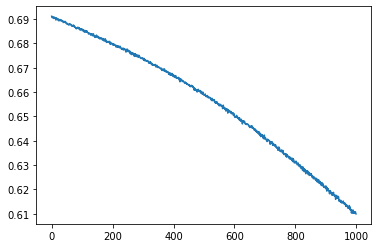

In [52]:
e = list(range(1000))
plt.plot(e, losses)

In [53]:
pred_score = []
for i in range(len(df)):
    embedding = bert_model.encode([df['cleaned_job_title'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),4)
    pred_score.append(pred)

df['RankNet_score'] = pred_score
df.sort_values(by ='star_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score,star_score,RankNet_score
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248,1.000000,0.8036
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,0.8265
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893,0.904915,1.000000,0.7609
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561,1.000000,0.9088
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,0.8412
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303,0.850071,0.850071,0.7937
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364,0.813627,0.813627,0.8847
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046,0.782046,0.8196
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441,0.750441,0.7872
15,67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.150093,0.748126,0.651694,0.733498,0.733498,0.7844


In [54]:
df.sort_values(by ='RankNet_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score,star_score,RankNet_score
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561,1.000000,0.9088
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364,0.813627,0.813627,0.8847
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,0.8412
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,0.8265
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046,0.782046,0.8196
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248,1.000000,0.8036
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303,0.850071,0.850071,0.7937
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,0.000000,0.480748,0.247452,0.732386,0.732386,0.7911
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441,0.750441,0.7872
15,67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.150093,0.748126,0.651694,0.733498,0.733498,0.7844


In [55]:
rank_model = RankNet(num_feature = 768)       
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)         
loss_fun = torch.nn.BCELoss()   

In [56]:
epoch = 1000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6943937540054321
Epoch100, loss : 0.519267737865448
Epoch200, loss : 0.5066618323326111
Epoch300, loss : 0.5034168362617493
Epoch400, loss : 0.502524197101593
Epoch500, loss : 0.5023928880691528
Epoch600, loss : 0.5012264847755432
Epoch700, loss : 0.501753032207489
Epoch800, loss : 0.5006658434867859
Epoch900, loss : 0.5016538500785828


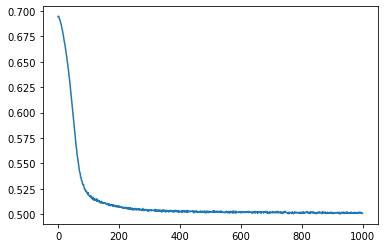

In [57]:
e = list(range(1000))
plt.plot(e, losses)

In [58]:
pred_score = []
for i in range(len(df)):
    embedding = bert_model.encode([df['cleaned_job_title'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),4)
    pred_score.append(pred)

df['RankNet_score'] = pred_score
df.sort_values(by ='star_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score,star_score,RankNet_score
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248,1.000000,0.9999
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,1.0000
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893,0.904915,1.000000,1.0000
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561,1.000000,1.0000
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,1.0000
8,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,seeking human resource human resource generali...,0.549286,0.865850,0.814303,0.850071,0.850071,0.9944
30,82,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,aspiring human resource professional energetic...,0.286577,0.824240,0.776364,0.813627,0.813627,0.9994
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046,0.782046,1.0000
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441,0.750441,0.9996
15,67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resource staffing recruiting professional,0.150093,0.748126,0.651694,0.733498,0.733498,0.9988


In [59]:
df.sort_values(by ='RankNet_score', ascending = False).head(20)

,id,job_title,location,connection,cleaned_job_title,tfidf_score,GloVe_score,Word2Vec_score,BERT_score,star_score,RankNet_score
45,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,1.0000
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspiring human resource professional,0.587267,0.891471,0.874753,0.888280,1.000000,1.0000
22,74,Human Resources Professional,Greater Boston Area,16,human resource professional,0.304885,0.834993,0.773886,0.782046,0.782046,1.0000
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,aspiring human resource specialist,0.517179,0.888843,0.841893,0.904915,1.000000,1.0000
13,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,seeking human resource opportunity,0.546943,0.913135,0.850321,0.908561,1.000000,1.0000
21,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspiring human resource manager seeking intern...,0.698165,0.922625,0.879166,0.732522,0.732522,0.9999
47,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,seeking human resource position,0.565839,0.862731,0.831308,0.923248,1.000000,0.9999
24,76,Aspiring Human Resources Professional | Passio...,"New York, New York",212,aspiring human resource professional passionat...,0.196396,0.793712,0.706361,0.720919,0.720919,0.9996
37,89,Director Human Resources at EY,Greater Atlanta Area,349,director human resource ey,0.167815,0.690886,0.544525,0.707826,0.707826,0.9996
42,94,Seeking Human Resources Opportunities. Open t...,USA,415,seeking human resource opportunity open travel...,0.299559,0.804127,0.696535,0.750441,0.750441,0.9996
